## Adversarial Autoencoders on fMRI Images for Automatic Data Generation
In this notebook and the corresponding repository, we will focus on the use of adversarial autoencoders to attack problems relating to generating a usable embedding for the space of sMRI images for the purpose of understanding psychiatric diseases.

This notebook written for and executed with Python 3.5, Keras 2.1.2 and Tensorflow r1.4.
### Data Setup
We will be using specifically preprocessed data for the project from ABIDE 1&2. Assuming that the instructions have been followed, we continue by selecting the 2mm dataset and .

In [1]:
import os
import string
import gzip
nii_files = []
for dirpath, sf, files in os.walk('depi-dataset_01'):
    if 'anat_mni_2mm.nii.gz' in files:
        nii_files.append(os.path.join(dirpath, 'anat_mni_2mm.nii.gz'))

In [2]:
for i in nii_files:
    decompressed_file = gzip.open(i)
    out_path = i.replace('/','_')[:-3]
    with open('depi_nii/' + out_path, 'wb') as outfile:
        outfile.write(decompressed_file.read())

### Data Processing
Data processing for this dataset is relatively straightforward; we delete the final voxel (which is always 0) so that the dimensionality of the spatial tensor has a high GCD.

In [ ]:
import nibabel as nib
import numpy as np
import copy
import h5py
import os

def save_large_dataset(file_name, variable):
    h5f = h5py.File(file_name + '.h5', 'w')
    h5f.create_dataset('variable', data=variable)
    h5f.close()

indir = 'depi_nii/'
Xs = []
for root, dirs, filenames in os.walk(indir):
    for f in filenames:
        if '.nii' == f[-4:]:
            img = nib.load(indir + f)
            data = img.dataobj # Get the data object
            data = data[:-1,:-1,:-1] # Clean the last dimension for a high GCD (all values are 0)
            X = np.expand_dims(data, -1)
            X = X / np.max(X)
            X = X.astype('float32')
            X = np.expand_dims(X, 0)
            print('Shape: ', X.shape)
            Xs.append(X)
            
Xa = np.vstack(Xs)
save_large_dataset('Xa', Xa)

### Training
We will use the [keras-adversarial library](https://github.com/bstriner/keras-adversarial) to help us with our training. We use [this example](https://github.com/bstriner/keras-adversarial/blob/master/examples/example_aae_cifar10.py) as a basis.

In [1]:
import os
import h5py
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.use('Agg')

from keras.layers import Input, Reshape, Flatten, Lambda, Dense, Conv3D, MaxPooling3D, UpSampling3D, TimeDistributed
from keras.models import Sequential, Model
from keras.optimizers import Adam
import keras.backend as K
from keras.engine.topology import Layer
from keras_adversarial.legacy import l1l2, Dense, fit, Convolution2D
from keras_adversarial import AdversarialModel, fix_names, n_choice
from keras_adversarial import AdversarialOptimizerSimultaneous, normal_latent_sampling
from keras.layers import LeakyReLU, Activation

import tensorflow as tf
import numpy as np

class SamplingLayer2D(Layer):
    def __init__(self, batch_size, n = 10, std = 1.0, **kwargs):
        self.n = n
        self.batch_size = batch_size
        self.std = std
        super(SamplingLayer2D, self).__init__(**kwargs)
    def build(self, input_shape):
        self.in_shape = input_shape
        choices = list(np.arange(self.n))
        choice_weights = np.arange(self.n) * (2 * np.pi) / (self.n) 
        W = np.vstack((np.cos(choice_weights), np.sin(choice_weights))).T
        self.W = K.variable(value=W)
        super(SamplingLayer2D, self).build(input_shape)
    def call(self, x):
        x = tf.tile(self.W, tf.constant([self.batch_size, 1]))
        y = x + K.random_normal(shape=K.shape(x), mean = 0.0, stddev=self.std)
        y = K.reshape(y, tf.stack((-1, 2)))
        y = tf.random_shuffle(y)
        y = y[:self.batch_size, :]
        y = K.reshape(y, tf.stack((-1, 2)))
        return y
    def compute_output_shape(self, input_shape):
        return (self.batch_size, 2)

def load_large_dataset(file_name):
    h5f = h5py.File(file_name + '.h5','r')
    variable = h5f['variable'][:]
    h5f.close()
    return variable

X = load_large_dataset('Xa')

def model_generator(latent_dim):
    latent_dim_2 = 3
    input_layer = Input((latent_dim,))
    x = Dense(5*6*5)(input_layer)
    x = Reshape((5, 6, 5, 1))(x)
    x = Conv3D(16, 3, 3, 3, activation='relu', border_mode='same')(x)
    x = UpSampling3D((2, 2, 2))(x)
    x = Conv3D(16, 3, 3, 3, activation='relu', border_mode='same')(x)
    x = UpSampling3D((3, 3, 3))(x)
    x = Conv3D(16, 3, 3, 3, activation='relu', border_mode='same')(x)
    x = UpSampling3D((3, 3, 3))(x)
    #x = Conv3D(32, 5, 5, 5, activation='relu', border_mode='same')(x)
    #x = UpSampling3D((2, 2, 2))(x)
    x = Conv3D(16, 3, 3, 3, activation='relu', border_mode='same')(x)
    x = Conv3D(16, 7, 7, 7, activation='relu', border_mode='same')(x)
    generated = Conv3D(1, 7, 7, 7, activation='linear', border_mode='same')(x)
    return Model(input_layer, generated, name='decoder')


def model_encoder(latent_dim, input_shape, reg=lambda: l1l2(1e-7, 0)):
    input_layer = Input(shape=X.shape[1:]) # Create the Input Layer
    x = Conv3D(8, 3, 3, 3, activation='relu', border_mode='same')(input_layer) 
    #x = Conv3D(8, 3, 3, 3, activation='relu', border_mode='same')(x) 
    x = MaxPooling3D((2, 2, 2), padding='same')(x)
    x = Conv3D(16, 3, 3, 3, activation='relu', border_mode='same')(x) 
    #x = Conv3D(16, 3, 3, 3, activation='relu', border_mode='same')(x) 
    x = MaxPooling3D((3, 3, 3), padding='same')(x)
    x = Conv3D(32, 3, 3, 3, activation='relu', border_mode='same')(x) 
    #x = Conv3D(32, 3, 3, 3, activation='relu', border_mode='same')(x) 
    x = MaxPooling3D((3, 3, 3), padding='same')(x)
    x = Flatten()(x)
    encoded = Dense(latent_dim)(x)
    #mu = Dense(latent_dim, name="encoder_mu", W_regularizer=reg())(x)
    #log_sigma_sq = Dense(latent_dim, name="encoder_log_sigma_sq", W_regularizer=reg())(x)
    #encoded = Lambda(lambda mulss : mulss[0] + K.random_normal(K.shape(mulss[0])) * K.exp(mulss[1] / 2),
    #           output_shape= (latent_dim,))([mu, log_sigma_sq])
    return Model(input_layer, encoded, name="encoder")


def model_discriminator(latent_dim, output_dim=1, units=256, reg=lambda: l1l2(1e-7, 1e-7)):
    input_layer = Input((latent_dim,))
    x = Dense(512, activation = 'tanh')(input_layer)
    x = Dense(64, activation = 'tanh')(x)
    y = Dense(1, activation = 'sigmoid')(x)
    return Model(input_layer, y)


def example_aae(path, adversarial_optimizer, latent_dim = 32):
    input_shape = X.shape[1:]

    # Specify the generator (z -> x)
    generator = model_generator(latent_dim)
    # Specify the encoder (x -> z)
    encoder = model_encoder(latent_dim, input_shape)
    # Combining the encoder and the generator, specify the autoencoder (x -> x')
    autoencoder = Model(encoder.inputs, generator(encoder(encoder.inputs)))
    # Specify the discriminator (z -> y)
    discriminator = model_discriminator(latent_dim)

    # build the AAE
    x = encoder.inputs[0]
    z = encoder(x)
    xpred = generator(z)
    zreal = SamplingLayer2D(10)(x)
    yreal = discriminator(zreal)
    yfake = discriminator(z)
    aae = Model(x, fix_names([xpred, yfake, yreal], ["xpred", "yfake", "yreal"]))

    # Generate summaries for the models
    generator.summary()
    encoder.summary()
    discriminator.summary()
    autoencoder.summary()

    # Build the adversarial model
    generative_params = generator.trainable_weights + encoder.trainable_weights
    model = AdversarialModel(base_model=aae,
                             player_params=[generative_params, discriminator.trainable_weights],
                             player_names=["generator", "discriminator"])
    model.adversarial_compile(adversarial_optimizer=adversarial_optimizer,
                              player_optimizers=[Adam(3e-4, decay=1e-4), Adam(1e-3, decay=1e-4)],
                              loss={"yfake": "binary_crossentropy", "yreal": "binary_crossentropy",
                                    "xpred": "mean_squared_error"},
                              player_compile_kwargs=[{"loss_weights": {"yfake": 1e-1, "yreal": 1e-1,
                                                                       "xpred": 1e2}}] * 2)

    # Split our data into training and testing
    xtrain = X[:1000]
    xtest = X[1000:1050]
    
    # train network
    # generator, discriminator; pred, yfake, yreal
    n = xtrain.shape[0]
    y = [xtrain, np.ones((n,)), np.zeros((n,)), xtrain, np.zeros((n,)), np.ones((n,))]
    ntest = xtest.shape[0]
    ytest = [xtest, np.ones((ntest,)), np.zeros((ntest,)), xtest, np.zeros((ntest,)), np.ones((ntest,))]
    history = fit(model, x=xtrain, y=y, validation_data=(xtest, ytest),
                  callbacks=[],
                  nb_epoch=100, batch_size=10)

    # save history
    df = pd.DataFrame(history.history)
    df.to_csv(os.path.join(path, "history.csv"))

    # save model
    encoder.save(os.path.join(path, "encoder.h5"))
    generator.save(os.path.join(path, "generator.h5"))
    discriminator.save(os.path.join(path, "discriminator.h5"))

example_aae("aae-smri-2", AdversarialOptimizerSimultaneous(), latent_dim=2)

Using TensorFlow backend.
/home/mehmet/miniconda2/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:58: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(16, (3, 3, 3), activation="relu", padding="same")`
/home/mehmet/miniconda2/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:60: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(16, (3, 3, 3), activation="relu", padding="same")`
/home/mehmet/miniconda2/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:62: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(16, (3, 3, 3), activation="relu", padding="same")`
/home/mehmet/miniconda2/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:66: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(16, (3, 3, 3), activation="relu", padding="same")`
/home/mehmet/miniconda2/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:67: UserWarning: Update your `Conv3D

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 150)               450       
_________________________________________________________________
reshape_1 (Reshape)          (None, 5, 6, 5, 1)        0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 5, 6, 5, 16)       448       
_________________________________________________________________
up_sampling3d_1 (UpSampling3 (None, 10, 12, 10, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 10, 12, 10, 16)    6928      
_________________________________________________________________
up_sampling3d_2 (UpSampling3 (None, 30, 36, 30, 16)    0         
__________

Epoch 6/100
1000/1000 [==============================] - 269s 269ms/step - loss: 1.5532 - generator_loss: 1.0085 - generator_xpred_loss: 0.0048 - generator_yfake_loss: 2.2714 - generator_yreal_loss: 3.0533 - discriminator_loss: 0.5447 - discriminator_xpred_loss: 0.0048 - discriminator_yfake_loss: 0.2299 - discriminator_yreal_loss: 0.4562 - val_loss: 1.7363 - val_generator_loss: 1.1045 - val_generator_xpred_loss: 0.0053 - val_generator_yfake_loss: 1.1769 - val_generator_yreal_loss: 4.5474 - val_discriminator_loss: 0.6318 - val_discriminator_xpred_loss: 0.0053 - val_discriminator_yfake_loss: 0.6263 - val_discriminator_yreal_loss: 0.3718
Epoch 7/100
1000/1000 [==============================] - 269s 269ms/step - loss: 1.4269 - generator_loss: 0.9012 - generator_xpred_loss: 0.0044 - generator_yfake_loss: 1.8651 - generator_yreal_loss: 2.7593 - discriminator_loss: 0.5257 - discriminator_xpred_loss: 0.0044 - discriminator_yfake_loss: 0.2567 - discriminator_yreal_loss: 0.6121 - val_loss: 1.408

Epoch 19/100
1000/1000 [==============================] - 269s 269ms/step - loss: 1.2490 - generator_loss: 0.8305 - generator_xpred_loss: 0.0032 - generator_yfake_loss: 2.2403 - generator_yreal_loss: 2.8561 - discriminator_loss: 0.4184 - discriminator_xpred_loss: 0.0032 - discriminator_yfake_loss: 0.2688 - discriminator_yreal_loss: 0.7064 - val_loss: 1.2958 - val_generator_loss: 0.7564 - val_generator_xpred_loss: 0.0041 - val_generator_yfake_loss: 1.0777 - val_generator_yreal_loss: 2.3567 - val_discriminator_loss: 0.5394 - val_discriminator_xpred_loss: 0.0041 - val_discriminator_yfake_loss: 0.4821 - val_discriminator_yreal_loss: 0.7828
Epoch 20/100
1000/1000 [==============================] - 269s 269ms/step - loss: 1.0922 - generator_loss: 0.6887 - generator_xpred_loss: 0.0032 - generator_yfake_loss: 1.6122 - generator_yreal_loss: 2.0888 - discriminator_loss: 0.4036 - discriminator_xpred_loss: 0.0032 - discriminator_yfake_loss: 0.2743 - discriminator_yreal_loss: 0.5757 - val_loss: 1.0

Epoch 32/100
1000/1000 [==============================] - 269s 269ms/step - loss: 1.0302 - generator_loss: 0.7103 - generator_xpred_loss: 0.0026 - generator_yfake_loss: 1.5504 - generator_yreal_loss: 2.9345 - discriminator_loss: 0.3199 - discriminator_xpred_loss: 0.0026 - discriminator_yfake_loss: 0.2424 - discriminator_yreal_loss: 0.3390 - val_loss: 1.0322 - val_generator_loss: 0.6734 - val_generator_xpred_loss: 0.0028 - val_generator_yfake_loss: 1.4535 - val_generator_yreal_loss: 2.4887 - val_discriminator_loss: 0.3588 - val_discriminator_xpred_loss: 0.0028 - val_discriminator_yfake_loss: 0.2855 - val_discriminator_yreal_loss: 0.5110
Epoch 33/100
1000/1000 [==============================] - 269s 269ms/step - loss: 1.1085 - generator_loss: 0.7446 - generator_xpred_loss: 0.0029 - generator_yfake_loss: 1.4007 - generator_yreal_loss: 3.1742 - discriminator_loss: 0.3639 - discriminator_xpred_loss: 0.0029 - discriminator_yfake_loss: 0.2934 - discriminator_yreal_loss: 0.4747 - val_loss: 1.1

Epoch 45/100
1000/1000 [==============================] - 269s 269ms/step - loss: 1.0054 - generator_loss: 0.6380 - generator_xpred_loss: 0.0026 - generator_yfake_loss: 1.0404 - generator_yreal_loss: 2.7028 - discriminator_loss: 0.3674 - discriminator_xpred_loss: 0.0026 - discriminator_yfake_loss: 0.4455 - discriminator_yreal_loss: 0.5924 - val_loss: 1.0658 - val_generator_loss: 0.7243 - val_generator_xpred_loss: 0.0026 - val_generator_yfake_loss: 1.0441 - val_generator_yreal_loss: 3.5961 - val_discriminator_loss: 0.3414 - val_discriminator_xpred_loss: 0.0026 - val_discriminator_yfake_loss: 0.4364 - val_discriminator_yreal_loss: 0.3746
Epoch 46/100
1000/1000 [==============================] - 269s 269ms/step - loss: 0.9952 - generator_loss: 0.6735 - generator_xpred_loss: 0.0024 - generator_yfake_loss: 1.1821 - generator_yreal_loss: 3.1412 - discriminator_loss: 0.3217 - discriminator_xpred_loss: 0.0024 - discriminator_yfake_loss: 0.3730 - discriminator_yreal_loss: 0.4323 - val_loss: 0.9

Epoch 58/100
1000/1000 [==============================] - 269s 269ms/step - loss: 1.1424 - generator_loss: 0.7013 - generator_xpred_loss: 0.0028 - generator_yfake_loss: 1.3284 - generator_yreal_loss: 2.8709 - discriminator_loss: 0.4411 - discriminator_xpred_loss: 0.0028 - discriminator_yfake_loss: 0.5613 - discriminator_yreal_loss: 1.0354 - val_loss: 1.0876 - val_generator_loss: 0.6849 - val_generator_xpred_loss: 0.0029 - val_generator_yfake_loss: 2.0514 - val_generator_yreal_loss: 1.9294 - val_discriminator_loss: 0.4027 - val_discriminator_xpred_loss: 0.0029 - val_discriminator_yfake_loss: 0.1380 - val_discriminator_yreal_loss: 1.0202
Epoch 59/100
1000/1000 [==============================] - 269s 269ms/step - loss: 0.9301 - generator_loss: 0.6104 - generator_xpred_loss: 0.0024 - generator_yfake_loss: 1.4170 - generator_yreal_loss: 2.2575 - discriminator_loss: 0.3197 - discriminator_xpred_loss: 0.0024 - discriminator_yfake_loss: 0.2835 - discriminator_yreal_loss: 0.4839 - val_loss: 0.9

Epoch 71/100
1000/1000 [==============================] - 269s 269ms/step - loss: 0.9722 - generator_loss: 0.6385 - generator_xpred_loss: 0.0022 - generator_yfake_loss: 1.0062 - generator_yreal_loss: 3.1436 - discriminator_loss: 0.3337 - discriminator_xpred_loss: 0.0022 - discriminator_yfake_loss: 0.4786 - discriminator_yreal_loss: 0.6228 - val_loss: 1.0359 - val_generator_loss: 0.6215 - val_generator_xpred_loss: 0.0025 - val_generator_yfake_loss: 0.5978 - val_generator_yreal_loss: 3.1203 - val_discriminator_loss: 0.4144 - val_discriminator_xpred_loss: 0.0025 - val_discriminator_yfake_loss: 0.9601 - val_discriminator_yreal_loss: 0.6871
Epoch 72/100
1000/1000 [==============================] - 269s 269ms/step - loss: 1.1399 - generator_loss: 0.7989 - generator_xpred_loss: 0.0026 - generator_yfake_loss: 2.1374 - generator_yreal_loss: 3.2795 - discriminator_loss: 0.3410 - discriminator_xpred_loss: 0.0026 - discriminator_yfake_loss: 0.3491 - discriminator_yreal_loss: 0.4887 - val_loss: 1.0

Epoch 84/100
1000/1000 [==============================] - 269s 269ms/step - loss: 0.9329 - generator_loss: 0.6180 - generator_xpred_loss: 0.0022 - generator_yfake_loss: 1.0607 - generator_yreal_loss: 2.9190 - discriminator_loss: 0.3149 - discriminator_xpred_loss: 0.0022 - discriminator_yfake_loss: 0.4278 - discriminator_yreal_loss: 0.5213 - val_loss: 0.9165 - val_generator_loss: 0.5784 - val_generator_xpred_loss: 0.0024 - val_generator_yfake_loss: 1.0356 - val_generator_yreal_loss: 2.3878 - val_discriminator_loss: 0.3380 - val_discriminator_xpred_loss: 0.0024 - val_discriminator_yfake_loss: 0.4412 - val_discriminator_yreal_loss: 0.5781
Epoch 85/100
1000/1000 [==============================] - 269s 269ms/step - loss: 0.9451 - generator_loss: 0.6272 - generator_xpred_loss: 0.0022 - generator_yfake_loss: 1.0567 - generator_yreal_loss: 3.0191 - discriminator_loss: 0.3180 - discriminator_xpred_loss: 0.0022 - discriminator_yfake_loss: 0.4317 - discriminator_yreal_loss: 0.5525 - val_loss: 0.9

Epoch 97/100
1000/1000 [==============================] - 269s 269ms/step - loss: 0.9629 - generator_loss: 0.6231 - generator_xpred_loss: 0.0024 - generator_yfake_loss: 1.1840 - generator_yreal_loss: 2.6374 - discriminator_loss: 0.3399 - discriminator_xpred_loss: 0.0024 - discriminator_yfake_loss: 0.4358 - discriminator_yreal_loss: 0.5534 - val_loss: 0.9877 - val_generator_loss: 0.6329 - val_generator_xpred_loss: 0.0024 - val_generator_yfake_loss: 0.8894 - val_generator_yreal_loss: 3.0717 - val_discriminator_loss: 0.3548 - val_discriminator_xpred_loss: 0.0024 - val_discriminator_yfake_loss: 0.5699 - val_discriminator_yreal_loss: 0.6096
Epoch 98/100
1000/1000 [==============================] - 269s 269ms/step - loss: 0.9193 - generator_loss: 0.5710 - generator_xpred_loss: 0.0023 - generator_yfake_loss: 0.9760 - generator_yreal_loss: 2.4752 - discriminator_loss: 0.3483 - discriminator_xpred_loss: 0.0023 - discriminator_yfake_loss: 0.5297 - discriminator_yreal_loss: 0.6937 - val_loss: 0.8

### Testing
Here, we load up the saved models to test whether our models can produce anything visually impressive:

In [1]:
import os
from keras.layers import Input, Dense, Conv3D, MaxPooling3D, UpSampling3D, Flatten, TimeDistributed, Reshape
from keras.models import load_model
from keras.optimizers import SGD
from keras.layers import Input, Dense, Reshape, Flatten, Permute, TimeDistributed, Activation, Lambda, multiply, subtract, concatenate
from keras.layers import SimpleRNN, LSTM, GRU, Conv2D, MaxPooling2D
from keras.losses import kullback_leibler_divergence
from keras.regularizers import L1L2, Regularizer
from keras.engine.topology import Layer
from keras.models import Model
from keras import backend as K
import tensorflow as tf
import numpy as np
import h5py

def load_large_dataset(file_name):
    h5f = h5py.File(file_name + '.h5','r')
    variable = h5f['variable'][:]
    h5f.close()
    return variable

X = load_large_dataset('Xa')
latent_dim = 2

class SamplingLayer2D(Layer):
    def __init__(self, batch_size, n = 10, std = 1.0, **kwargs):
        self.n = n
        self.batch_size = batch_size
        self.std = std
        super(SamplingLayer2D, self).__init__(**kwargs)
    def build(self, input_shape):
        self.in_shape = input_shape
        choices = list(np.arange(self.n))
        choice_weights = np.arange(self.n) * (2 * np.pi) / (self.n) 
        W = np.vstack((np.cos(choice_weights), np.sin(choice_weights))).T
        self.W = K.variable(value=W)
        super(SamplingLayer2D, self).build(input_shape)
    def call(self, x):
        #x = tf.einsum('ai,jk->ajk', x, self.W)
        x = tf.tile(self.W, tf.constant([self.batch_size, 1]))
        #element_choices = tf.convert_to_tensor(self.choices)
        #indices = tf.multinomial(tf.log([self.weights]), self.batch_size)
        #y = self.W + K.random_normal(shape=K.shape(self.W), mean = 0.0, stddev=self.std)
        y = x + K.random_normal(shape=K.shape(x), mean = 0.0, stddev=self.std)
        y = K.reshape(y, tf.stack((-1, 2)))
        y = tf.random_shuffle(y)
        y = y[:self.batch_size, :]
        y = K.reshape(y, tf.stack((-1, 2)))
        return y
    def compute_output_shape(self, input_shape):
        return (self.batch_size, 2)
    
data = np.zeros((96, 1))

i = Input(shape=data.shape[1:])
x = SamplingLayer2D(32, std=0.05)(i)

sampler = Model(inputs=i, outputs=[x])
sampler.compile(optimizer='sgd', loss='mse')

zsamples = sampler.predict(data, batch_size = 32)

encoder = load_model('aae-smri-2/encoder.h5')
generator = load_model('aae-smri-2/generator.h5')
#discriminator = load_model('aae-fmri/discriminator.h5')
#zsamples = np.random.normal(size=(100, latent_dim))
outs = generator.predict(zsamples, batch_size = 2)
# random_generator = generator(normal_latent_sampling((X.shape[1], latent_dim,)))(input_layer)

Using TensorFlow backend.
/home/mehmet/miniconda2/envs/tensorflow/lib/python3.5/site-packages/keras/models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Let us first show a 2D slice from the real data:

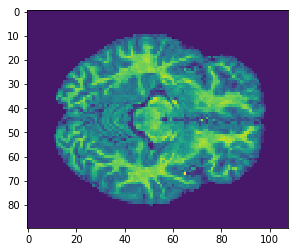

In [2]:
from matplotlib import pyplot as plt
my_slice = X[0,:,:,30,0]
%matplotlib inline
plt.imshow(my_slice, interpolation='nearest')
plt.show()

Let us now show an output from the trained model:

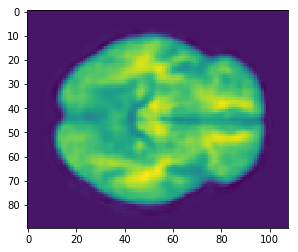

In [3]:
from matplotlib import pyplot as plt
my_slice = outs[55,:,:,30,0]
%matplotlib inline
plt.imshow(my_slice / np.max(my_slice), interpolation='nearest')
plt.show()

It is alive!